# Machine Learning Force Field usando VASP, MACE e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

from ase.io import write, read
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

Nesse tutorial iremos aprender como melhorar modelos de MLIP usando modelos de estado da arte como [foundation models](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) baseados na arquitetura [MACE](https://mace-docs.readthedocs.io/en/latest/index.html). Discutiremos também como realizar o [fine tunning](https://mace-docs.readthedocs.io/en/latest/guide/finetuning.html) do modelo com novos cálculos ab initio realizados com VASP. 

## Passo -1: Instalar MACE e suas dependências

Se você ainda não instalou o MACE, deveria fazê-lo com os seguintes comandos em um terminal:

1. Crie um ambiente `conda`:
```bash
conda create -n mlff -c conda-forge python==3.10
conda activate mlff
```

2. Instale `ase` e `numpy` com as versões apropriadas
```bash
pip install --upgrade ase numpy==2.0 ipykernel matplotlib pandas
```

3. Instale `AseMolec` para algumas análises
```bash
pip install git+https://github.com/imagdau/aseMolec@f411b5618381ba3b807cbbb041f12f460a69d606
```

4. Instale a versão do `pytorch` compatível com sua GPU
```bash
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
```

5. Instale `mace-torch`
```bash
pip install mace-torch cuequivariance cuequivariance-torch cuequivariance-ops-torch-cu12 torch-dftd
```

## Passo 0: Criando uma função auxiliar que faz dinâmica Molecular no ASE

In [5]:
np.random.seed(701) #just making sure the MD failure is reproducible

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.calc = calc

    #initialize the temperature

    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 0.5*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace'] = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['force_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Passo 1: Fazendo MD usando _foundation models_ from MACE

Lembre-se de usar o kernel no VScode de `mlff`

Os modelos fundamentais mudaram tudo. O MACE-MP-0 é um modelo treinado com mais de 1 milhão de cálculos de DFT e é capaz de rodar dinâmicas para toda a tabela periódica.

O MACE fornece uma interface simples para carregar um modelo fundamental, que podemos usar agora. Consulte a [documentação](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) para mais detalhes.

In [3]:
from mace.calculators import mace_mp

macemp = mace_mp(model="small", dispersion=True, default_dtype = "float32", device="cuda")

/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Using Materials Project MACE for MACECalculator with /home/elvis/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


Carregando arquivo de configuração inicial para rodar MD

In [ ]:
init_conf = read('mace/ic_32h2o_300K.pdb')

simpleMD(init_conf, temp=300, calc=macemp, fname='mace/mace_md_32h2o_300K.xyz', s=10, T=10000)

Obs: Demorou ~15 min, comparados com os 880 minutos do cálculo Ab Initio feito usando o VASP na Aula 07. 

## Passo 2: Comparando resultados de energia com cálculos Ab Initio do VASP

Criando calculadora do VASP para realizar single point SCF: `ibrion=-1`

In [3]:
vasp_calc = Vasp(
    directory='mace/32h2o_scf',
    xc='pbe',
    encut=400,
    ivdw=12, vdw_radius = 10, vdw_cnradius = 10,          # D3(BJ) van der Waals correction
    ismear=0, sigma=0.1,
    ediff=1e-4,       
    isym=0,
    ibrion=-1, nelm=100,                            # single point SCF calculation
    lreal = 'Auto', lwave=False, lcharg=False, lvtot=False
)

Efetuando os cálculos ab initio para alguns frames da trajetória `.xyz`

In [ ]:
from tqdm import tqdm
print("Evaluating MACE configurations with VASP")
traj = read('mace/mace_md_32h2o_300K.xyz', ':')

for at in tqdm(traj[::5]): # lendo every 5 frames to save time
    at.calc = vasp_calc
    at.info['energy_vasp'] = at.get_potential_energy()
    at.arrays['forces_vasp'] = at.get_forces()
    at.calc = None  #remove calculator to save memory

Evaluating MACE configurations with VASP


100%|██████████| 201/201 [58:47<00:00, 17.55s/it] 


Gravando informações em um novo arquivo só com os frames re-calculados. 

Nesse arquivo temos `energy_mace`, `energy_vasp`, `forces_mace` e `forces_vasp`

In [6]:
write('mace/mace_md_32h2o_300K_200frames.xyz', traj[::5]) #save full result

Carregando arquivo para comparar as energias. 

Text(0, 0.5, 'Total Energy per Atom (eV)')

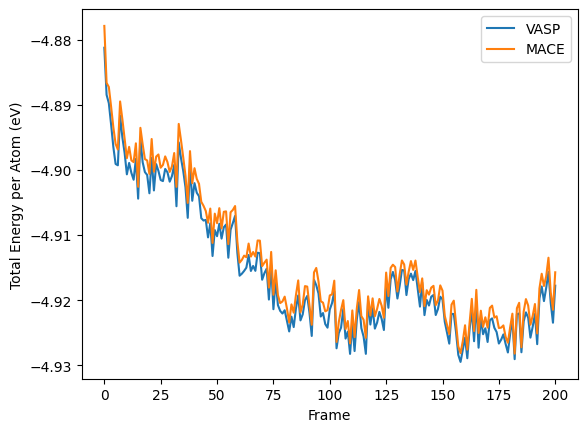

In [7]:
from aseMolec import extAtoms as ea

traj = read('mace/mace_md_32h2o_300K_200frames.xyz', ':')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_vasp', peratom=True), label='VASP')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_mace', peratom=True), label='MACE')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Total Energy per Atom (eV)')

## Passo 3: Realizando _fine tunning_ da rede MACE

Definindo arquivos para treino e para teste

In [3]:
traj = read('mace/mace_md_32h2o_300K_200frames.xyz', ':')
write('mace/mace_md_32h2o_300K_train.xyz', traj[:150])
write('mace/mace_md_32h2o_300K_test.xyz', traj[150:])

Realizando treinamento da rede `MACE` com o foundation model

In [4]:
!mace_run_train \
    --name="finetuned_MACE" \
    --foundation_model="small" \
    --multiheads_finetuning=False \
    --stress_weight=0.0 \
    --forces_weight=1.0 \
    --energy_weight=1.0 \
    --model_dir="mace" \
    --log_dir="mace" \
    --checkpoints_dir="mace" \
    --train_file="mace/mace_md_32h2o_300K_train.xyz" \
    --valid_fraction=0.9 \
    --test_file="mace/mace_md_32h2o_300K_test.xyz" \
    --energy_key="energy_vasp" \
    --forces_key="forces_vasp" \
    --E0s="average" \
    --lr=0.01 \
    --scaling="rms_forces_scaling" \
    --batch_size=2 \
    --max_num_epochs=6 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --default_dtype="float64" \
    --device=cuda \
    --seed=3

/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
2025-12-03 10:19:25.746 INFO: ===========VERIFYING SETTINGS===========
2025-12-03 10:19:25.746 INFO: MACE version: 0.3.14
2025-12-03 10:19:25.881 INFO: CUDA version: 12.8, CUDA device: 0
2025-12-03 10:19:25.969 INFO: Using foundation model mace-mp-0 small as initial checkpoint.
Using Materials Project MACE for MACECalculator with /home/elvis/.cache/mace/20231210mace128L0_energy_epoch249model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environ

## Passo 5: Usando modelo finetunning

In [6]:
from mace.calculators import MACECalculator

macenew = MACECalculator(model_path="mace/finetuned_MACE.model", device="cuda",default_dtype = "float32")

/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


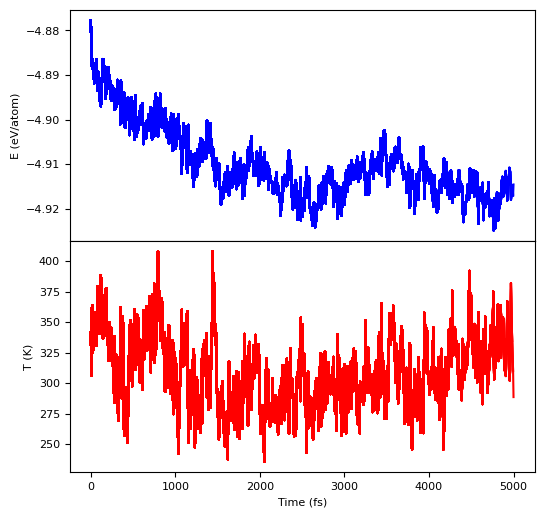

MD finished in 13.88 minutes!


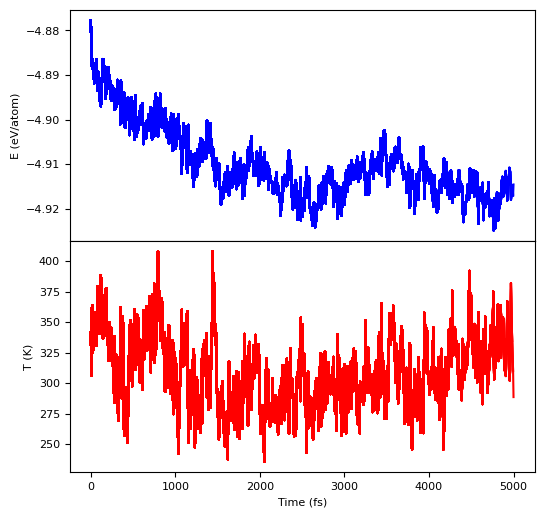

In [30]:
#let us start with a single molecule
init_conf = read('aimd_32h2o_300K_5ps/CONTCAR')

#we can use MACE as a calculator in ASE!
simpleMD(init_conf, temp=300, calc=macenew, fname='mace/mymace_md_32h2o_300K.xyz', s=10, T=10000)